# Fáza 3 - strojové učenie

Pri dátovej analýze nemusí byť naším cieľom získať len znalosti obsiahnuté v aktuálnych dátach, ale aj natrénovať model, ktorý bude schopný robiť rozumné predikcie pre nové pozorovania pomocou strojového učenia.
V tejto fáze sa od Vás očakáva:

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.stats as sm_stats

import datetime
import re
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from numpy import percentile

import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer, QuantileTransformer

from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectPercentile, SelectFromModel
from sklearn.feature_selection import mutual_info_regression, chi2, f_regression, f_classif
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [2]:
def phase1():
    labor = pd.read_csv("046/labor.csv", sep='\t')
    labor.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
    labor = labor.drop(["index", "name"], axis=1)
    smoker_encoding = {"Y": 1, "N": 0, "yes": 1, "no": 0}
    labor["smoker"].replace(smoker_encoding, inplace=True)

    profiles = pd.read_csv("046/profiles.csv", sep='\t')
    profiles.rename(columns = {"Unnamed: 0": "index"}, inplace = True)
    profiles = profiles.drop(["index"], axis=1)
    profiles["race"].replace({"black": "Black", "white": "White", "blsck": "Black"}, inplace=True)
    profiles["birthdate"] = pd.to_datetime(profiles['birthdate'], utc=False)

    merged = pd.merge(profiles, labor, how='outer', on='ssn')
    merged = merged.drop(["ssn"], axis=1)
    return merged

class handleNA(TransformerMixin):
    def __init__(self, method, strategy=None):
        self.method = method
        self.strategy = strategy
        
    def removeNA(self, merged):
        return merged.dropna()

    def getNAcols(self, merged):
        return merged.columns[merged.isnull().any()].tolist()

    def replaceNaN(self, original_merged):
        na_cols = self.getNAcols(original_merged)
        strategy = self.strategy
        new_merged = original_merged.copy()
        if strategy == "kNN":
            imp_strategy = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    #         imp_strategy = KNNImputer()
        elif strategy == "mean" or strategy == "median":    
            imp_strategy = SimpleImputer(missing_values=np.nan, strategy=strategy)
        else:
            raise Exception("Unsupported strategy")
        for col in na_cols:
            new_merged[col] = imp_strategy.fit_transform(new_merged[[col]])
        return new_merged
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'nothing':
            return X
        elif self.method == 'remove':
            return self.removeNA(X);
        elif self.method == 'replace':
            return self.replaceNaN(X)
        else:
            raise Exception("Unsupported method")
            
class handleOutliers(TransformerMixin):
    def __init__(self, method):
        self.method = method
        
    def onlyNumCols(self, merged):
        return merged.drop(["residence", "job", "company", "name", "birthdate"], axis=1, errors='ignore')

    def identify_outliers(self, merged):
        suma = 0;
        for col in merged.columns:
            q25, q75 = percentile(merged[col], 25), percentile(merged[col], 75)
            iqr = q75 - q25
            cut_off = iqr * 1.5
            lower, upper = q25 - cut_off, q75 + cut_off
            outliers = merged[((merged[col] < lower) | (merged[col] > upper))] 
            print(col, 'Identified outliers: %d' % len(outliers))
            suma += len(outliers)
        print('Sum of identified outliers: %d' % suma)

    def remove_outliers(self, merged):
        newMerged = merged.copy()
        for col in newMerged.columns:
            q25, q75 = percentile(newMerged[col], 25), percentile(newMerged[col], 75)
            iqr = q75 - q25
            cut_off = iqr * 1.5
            lower, upper = q25 - cut_off, q75 + cut_off
            newMerged = newMerged[((newMerged[col] >= lower) & (newMerged[col] <= upper))] 
        return newMerged

    def replace_outliers(self, merged):
        newMerged = merged.copy()
        for col in newMerged.columns:
            q05, q95 = percentile(newMerged[col], 5), percentile(newMerged[col], 95)
            newMerged[col] = np.where(newMerged[col] < q05, q05, newMerged[col])
            newMerged[col] = np.where(newMerged[col] > q95, q95, newMerged[col])
        return newMerged
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'nothing':
            return self.onlyNumCols(X)
        elif self.method == 'remove':
            return self.remove_outliers(self.onlyNumCols(X))
        elif self.method == 'replace':
            return self.replace_outliers(self.onlyNumCols(X))
        else:
            raise Exception("Unsupported method")
            
class handleCategorical(TransformerMixin):
    def transformResidenceNLP(self, merged):
        for i in merged['residence'].index:
            country_code = re.findall('[A-Z]{2} [0-9]{5}', str(merged['residence'][i]))[0]
            merged.at[i, 'state']=re.findall('[A-Z]{2}', country_code)[0]
        len(merged['state'].value_counts())
        return merged.drop('residence', axis=1)

    def encodeOrdinal(self, merged):
        transformed = self.transformResidenceNLP(merged)
        ce_ordinal = ce.OrdinalEncoder(cols=['race', 'state', 'blood_group', 'relationship'])
        encoded = ce_ordinal.fit_transform(transformed)
        return encoded

    def frombirthtoage(self, born):
        now = datetime.date.today()
        return now.year - born.year - ((now.month, now.day) < (born.month, born.day))

    def computeAge(self, merged):
        ages = merged['birthdate'].apply(lambda d: self.frombirthtoage(d))
        merged = merged.assign(age=ages.values)
        return merged.drop('birthdate', axis=1)

    def encodeOneHot(self, merged):
        ce_OHE = ce.OneHotEncoder(cols=['sex'], use_cat_names=True)
        merged = ce_OHE.fit_transform(merged)
        return merged

    def fit(self, X):
        return self
    
    def transform(self, X):
        new_data = self.encodeOrdinal(X)
        new_data = self.computeAge(new_data)
        new_data = self.encodeOneHot(new_data)    
        return new_data
    
class handleTransformations(TransformerMixin):
    def __init__(self, method):
        self.method = method
        
    def transformPower(self, merged):
        power = PowerTransformer(method='yeo-johnson', standardize=True)
        merged_without_indicator = merged.drop('indicator', axis=1)
        indicator = merged['indicator']
        df_return = pd.DataFrame(power.fit_transform(merged_without_indicator), columns = merged_without_indicator.columns)
        df_return = pd.concat([df_return, indicator], axis=1)
        return df_return
    
    def transormQuan(self, merged):
        quan = QuantileTransformer(n_quantiles=10, random_state=0)
        merged_without_indicator = merged.drop('indicator', axis=1)
        indicator = merged['indicator']
        df_return = pd.DataFrame(quan.fit_transform(merged_without_indicator), columns = merged_without_indicator.columns)
        df_return = pd.concat([df_return, indicator], axis=1)
        return df_return
    
    def scaleMM(self, merged):
        norm_s = MinMaxScaler()
        merged_without_indicator = merged.drop('indicator', axis=1)
        indicator = merged['indicator']
        df_return = pd.DataFrame(norm_s.fit_transform(merged_without_indicator), columns = merged_without_indicator.columns)
        df_return = pd.concat([df_return, indicator], axis=1)
        return df_return
        
    def scaleS(self, merged):
        stan_s = StandardScaler()
        merged_without_indicator = merged.drop('indicator', axis=1)
        indicator = merged['indicator']
        df_return = pd.DataFrame(stan_s.fit_transform(merged_without_indicator), columns = merged_without_indicator.columns)
        df_return = pd.concat([df_return, indicator], axis=1)
        return df_return
    
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.method == 'nothing':
            return X
        elif self.method == 'power':
            return self.transformPower(X)
        elif self.method == 'quan':
            return self.transormQuan(X)
        elif self.method == 'minmax':
            return self.scaleMM(X)
        elif self.method == 'standard':
            return self.scaleS(X)
        else:
            raise Exception("Unsupported method")

class handleSelection(TransformerMixin):
    def __init__(self, list_attributes):
        self.list_attributes = list_attributes
        
    def fit(self, X):
        return self
    
    def transform(self, X):
        if self.list_attributes == 'all':
            return X
        else:
            return X[self.list_attributes]

# Opravil som handleTransformations aby netransformovalo indicator, cele to pojde do skriptu

In [3]:
def pipelineGenerator(na_method='remove', na_strategy=None, outliers_method='nothing', 
                      tranformation_method='nothing', select_attributes='all'):
    pipeline =  Pipeline([
        ('handleCategorical', handleCategorical()),
        ('handleNA', handleNA(na_method, na_strategy)), # possible: 'nothing'; 'remove'; 'replace', 'mean'; 'replace', 'median'; 'replace', 'kNN'
        ('handleOutliers', handleOutliers(outliers_method)), # possible: 'nothing'; 'remove'; 'replace'
        ('handleTransformations', handleTransformations(tranformation_method)), # possible: 'nothing'; 'power'; 'quan'; 'minmax'; 'standard'
        ('handleSelection', handleSelection(select_attributes)) # possible: 'all'; list of attributes
    ])
    return pipeline

In [4]:
original_data = phase1()
pipeline = pipelineGenerator(na_method='replace', na_strategy='mean', outliers_method='replace', 
                              tranformation_method='power', select_attributes='all')
transformed_data = pipeline.fit_transform(original_data)
transformed_data

C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,race,blood_group,sex_F,sex_M,weight,hemoglobin,alp,etytr,alt,erytrocyty,...,hematokrit,er-cv,leukocyty,smoker,relationship,ast,trombocyty,state,age,indicator
0,-0.927752,-1.631908,0.985705,-0.985705,0.004631,-0.228413,0.762040,-0.822680,-0.554042,-0.740837,...,1.762792,-0.654331,0.575148,-0.818062,-1.388580,-1.835066,-1.834156,-1.790999,-1.362675,0.0
1,-0.927752,-1.631908,0.985705,-0.985705,-0.943402,-1.498181,0.449045,-0.716693,-1.668198,-1.158205,...,1.762792,0.397082,1.741017,-0.818062,-0.712578,-0.850796,-1.107238,-1.790999,-1.362675,1.0
2,-0.927752,-1.631908,0.985705,-0.985705,-0.226488,0.905449,-1.427225,1.706577,-0.947798,-0.757217,...,0.471032,-1.854965,-0.649794,-0.818062,-0.107049,0.434211,1.031946,-1.790999,-1.362675,1.0
3,-0.927752,-1.631908,0.985705,-0.985705,1.531930,0.864772,-1.595630,-0.983557,-1.764159,-1.211000,...,0.016238,0.946372,0.237190,-0.818062,-0.107049,0.089598,-0.356376,-1.790999,-1.362675,0.0
4,0.256291,-1.091601,0.985705,-0.985705,1.141908,-0.126439,0.782842,-0.773561,-0.097001,0.287176,...,-1.585082,-0.807427,-1.311161,-0.818062,0.450948,1.078636,1.509589,-1.790999,-0.127477,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,1.231360,-1.091601,-1.014502,1.014502,-0.141931,-0.434771,0.999915,0.354780,-0.536954,-0.262434,...,1.762792,0.163015,-1.425585,-0.818062,-0.107049,-1.626261,-1.706319,0.690496,0.619720,1.0
9998,1.231360,-1.091601,-1.014502,1.014502,1.718199,-1.331923,0.891675,-1.039110,0.592758,0.409968,...,-0.625331,0.355659,0.362799,1.222401,0.973776,1.758767,-0.090255,0.690496,0.619720,1.0
9999,1.231360,-0.144903,0.985705,-0.985705,-0.973863,0.979050,-1.470309,-1.816919,-0.860196,-1.376637,...,-0.895445,-1.499287,-1.127353,1.222401,-0.712578,-1.835066,0.634241,0.862978,1.172639,1.0
10000,1.231360,-0.144903,0.985705,-0.985705,0.737314,1.191818,-1.435884,0.720815,1.826140,1.793760,...,-0.778025,1.104705,-1.157182,-0.818062,-1.388580,-1.236976,1.790485,0.862978,1.172639,1.0


In [5]:
def pipetofile(transformed_data, X_train, X_test, y_train, y_test):
    X_train.to_csv('processed_data_after_phase_2_X_train.csv', sep='\t')
    X_test.to_csv('processed_data_after_phase_2_X_test.csv', sep='\t')
    y_train.to_csv('processed_data_after_phase_2_y_train.csv', sep='\t')
    y_test.to_csv('processed_data_after_phase_2_y_test.csv', sep='\t')

In [6]:
# list_attributes = ['leukocyty', 'etytr', 'hematokrit','alp', 'state', 'indicator']
list_attributes = ['leukocyty', 'etytr', 'hematokrit','alp', 'ast', 'indicator']
# list_attributes = list(transformed_data.columns)
preprocessed_data = transformed_data[list_attributes]
X_train, X_test, y_train, y_test = train_test_split(preprocessed_data.drop(['indicator'], axis=1), 
                                                    preprocessed_data['indicator'], test_size=0.33)
# pipetofile(pipeline1, X_train, X_test, y_train, y_test)

In [7]:
X_train

,leukocyty,etytr,hematokrit,alp,ast
938,-0.068094,1.044681,-1.164051,1.111558,-0.775515
8253,0.587879,0.036121,0.376727,0.490522,-0.220970
6655,0.670091,0.443169,-0.881908,-0.093600,1.345910
2369,-1.156393,-1.488647,-1.824953,-1.595630,-0.536215
9622,-1.213082,1.313631,1.147933,-0.626768,-0.452857
...,...,...,...,...,...
7937,0.372787,1.706577,0.308481,-0.353501,-0.552474
2052,0.696133,-0.628344,0.020463,1.009818,0.527444
1382,0.883629,-1.179919,0.162119,1.328639,-1.835066
9719,-0.566710,0.832660,-0.332409,-0.693595,1.110212


In [8]:
X_test

,leukocyty,etytr,hematokrit,alp,ast
5913,1.065396,-0.257515,1.558121,-0.086463,0.561027
5754,-1.711513,0.099659,0.688099,0.424400,1.732113
2336,0.759131,-0.236308,-0.599511,0.551152,0.290469
1857,0.676037,0.746840,-1.760637,-0.646764,0.385991
5605,0.698965,1.706577,-0.301976,-1.061171,-1.460101
...,...,...,...,...,...
1443,0.158239,-0.439048,0.257281,-0.790564,1.647172
8295,0.007646,-1.019089,1.190953,0.398182,0.262711
410,-0.012789,-1.816919,1.762792,1.328639,0.614727
3964,-0.562335,1.706577,1.266477,-1.595630,1.747218


In [9]:
y_train

938     1.0
8253    0.0
6655    0.0
2369    1.0
9622    1.0
       ... 
7937    1.0
2052    1.0
1382    1.0
9719    1.0
9434    1.0
Name: indicator, Length: 6701, dtype: float64

In [10]:
y_test

5913    0.0
5754    1.0
2336    0.0
1857    0.0
5605    0.0
       ... 
1443    0.0
8295    0.0
410     0.0
3964    1.0
8423    0.0
Name: indicator, Length: 3301, dtype: float64

## 1. Manuálne vytvorenie a vyhodnotenie rozhodovacích pravidiel pre klasifikáciu (5b)
* Naimplementujte 1R algorithm (1R or OneR), ktorý je jednoduchá klasifikácia t.j. rozhodnutie na základe jedného atribútu. Môžete implementovať komplikovanejšie t.j. zahŕňajúce viacero atribútov (ich kombinácie).
* Pravidlá by v tomto kroku mali byť vytvorené manuálne na základe pozorovaných závislostí v dátach. Vyhodnoťte klasifikátor pomocou metrík accuracy, precision a recall.

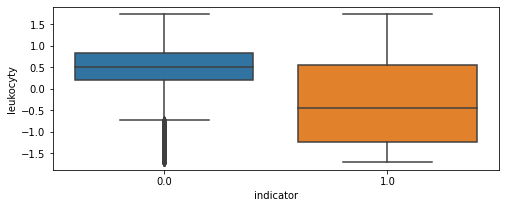

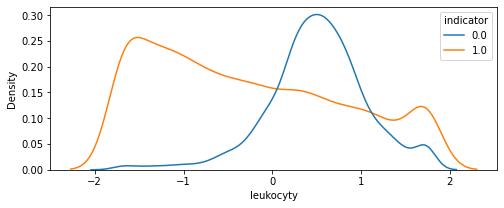

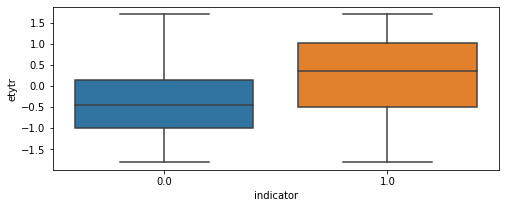

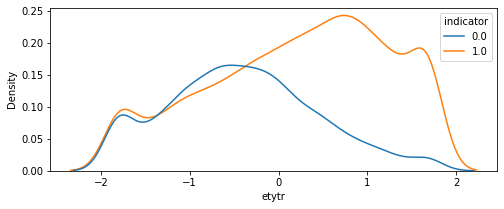

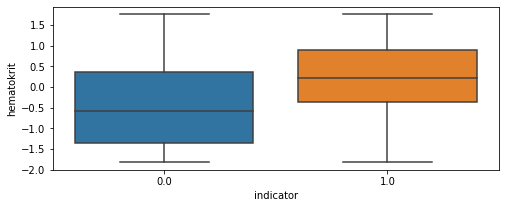

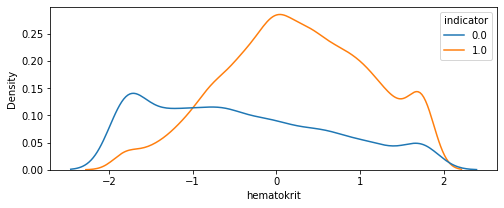

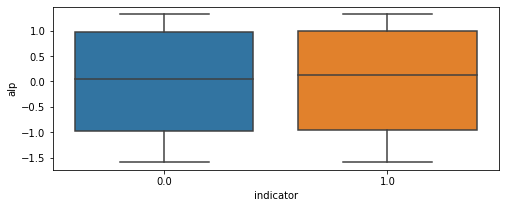

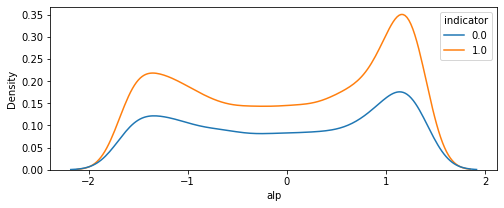

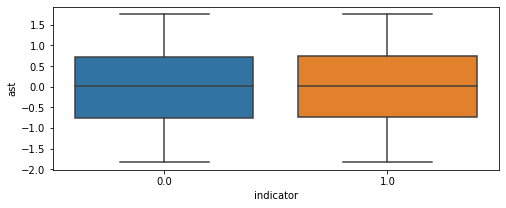

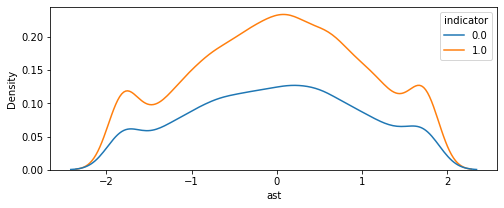

In [11]:
attributes = list_attributes.copy()
attributes.remove('indicator')
for col in attributes:
    fig_01 = plt.subplots(figsize = (8, 3))
    sns.boxplot(x='indicator', y=col, data=preprocessed_data)
    fig_01 = plt.subplots(figsize = (8, 3))
    sns.kdeplot(data=preprocessed_data, x=col, hue="indicator")

cca 60 riadkov kodu vlastny algoritmus

In [92]:
def rule1(row):
    if row['leukocyty'] > 0 and row['leukocyty'] < 1.2:
        return 0
    else:
        return 1

def oner(data):
    return data.apply(lambda row: rule1(row), axis=1)

In [93]:
pred = oner(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

         0.0       0.62      0.74      0.68      2409
         1.0       0.84      0.74      0.79      4292

    accuracy                           0.74      6701
   macro avg       0.73      0.74      0.73      6701
weighted avg       0.76      0.74      0.75      6701



In [94]:
pred = oner(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         0.0       0.62      0.77      0.69      1170
         1.0       0.86      0.74      0.79      2131

    accuracy                           0.75      3301
   macro avg       0.74      0.76      0.74      3301
weighted avg       0.77      0.75      0.76      3301



In [74]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
pred = dummy_clf.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      2409
         1.0       0.64      1.00      0.78      4292

    accuracy                           0.64      6701
   macro avg       0.32      0.50      0.39      6701
weighted avg       0.41      0.64      0.50      6701



C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\PeterSmrecek\Documents\IAU-repository\IAU-virtual\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

In [13]:
from sklearn.tree import DecisionTreeClassifier
# cls = DecisionTreeClassifier(criterion='entropy')
cls = DecisionTreeClassifier(max_depth=5)
# cls = DecisionTreeClassifier()
cls.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

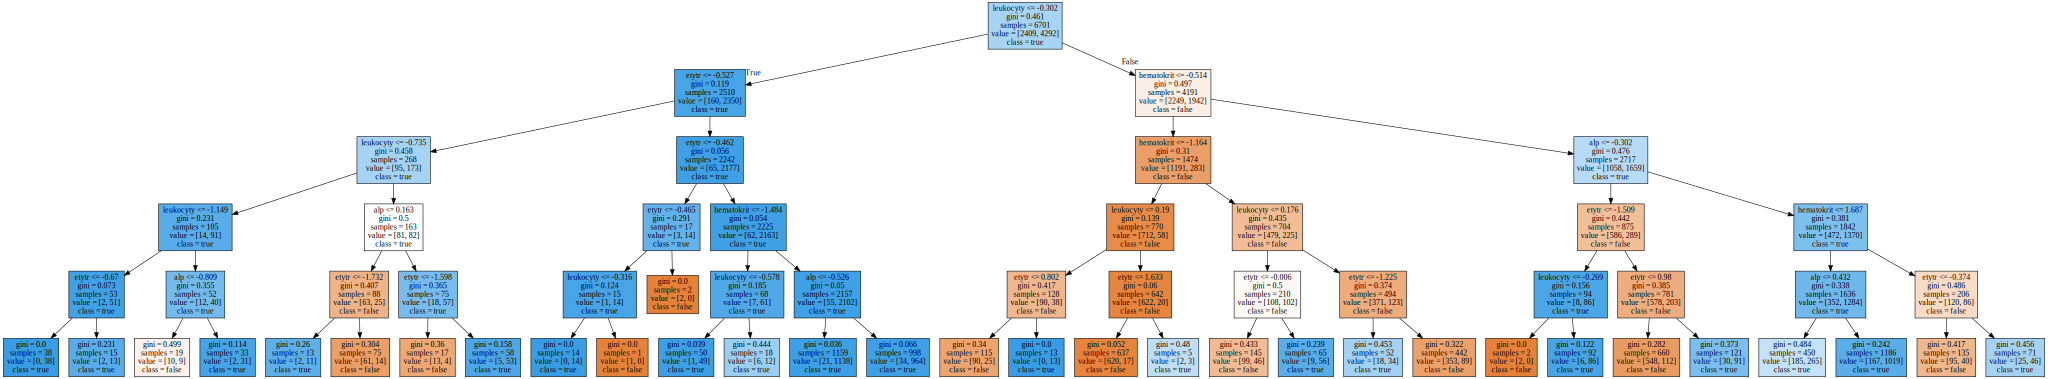

In [14]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

graph = Source(export_graphviz(cls, 
                               out_file=None,
                               feature_names=X_train.columns,
                               class_names=['false', 'true'],
                               filled = True))

display(SVG(graph.pipe(format='svg')))

from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku
style = "<style>svg{width:40% !important;height:70% !important;}</style>"
HTML(style)

In [15]:
from sklearn.metrics import classification_report
pred = cls.predict(X_train)
print(classification_report(y_train, pred))

              precision    recall  f1-score   support

         0.0       0.84      0.79      0.81      2409
         1.0       0.88      0.92      0.90      4292

    accuracy                           0.87      6701
   macro avg       0.86      0.85      0.86      6701
weighted avg       0.87      0.87      0.87      6701



In [59]:
from sklearn.metrics import classification_report
pred = cls.predict(X_test)
print(classification_report(y_test, pred))

[1. 1. 0. ... 0. 1. 0.]
              precision    recall  f1-score   support

         0.0       0.81      0.77      0.79      1170
         1.0       0.88      0.90      0.89      2131

    accuracy                           0.85      3301
   macro avg       0.84      0.83      0.84      3301
weighted avg       0.85      0.85      0.85      3301



## 2. Natrénovanie a vyhodnotenie klasifikátora strojového učenia (5b)
* Na trénovanie využite minimálne jeden stromový algoritm strojového učenia v scikit-learn.
* Vizualizujte natrénované pravidlá.
* Vyhodnoťte natrénovaný model pomocou metrík accuracy, precision a recall
* Porovnajte natrénovaný klasifikátor s Vašimi manuálne vytvorenými pravidlami z prvého kroku.

## 3. Optimalizácia - hyperparameter tuning (5b)
* Preskúmajte hyperparametre Vášho zvoleného klasifikačného algoritmu v druhom kroku a vyskúšajte ich rôzne nastavenie tak, aby ste minimalizovali overfitting (preučenie) a optimalizovali výsledok. 
* Vysvetlite, čo jednotlivé hyperparametre robia. Pri nastavovaní hyperparametrov algoritmu využite krížovú validáciu (cross validation) na trénovacej množine.

## 4. Vyhodnotenie vplyvu zvolenej stratégie riešenia na klasifikáciu (5b)
Vyhodnotíte Vami zvolené stratégie riešenia projektu z hľadiska classification accuracy: 

* Stratégie riešenia chýbajúcich hodnôt a outlierov;
* Scaling resp. transformer či zlepší accuracy klasifikácie;
* Výber atribútov a výber algoritmov;
* Hyperparameter tuning resp. ensemble learning.

Ktorý spôsob z každého hore-uvedených bodov sa ukázal ako vhodnejší pre daný problém? Vyhodnotenie podložíte dôkazmi.

Správa sa odovzdáva v 12. týždni semestra
* Na cvičení, dvojica svojmu cvičiacemu odprezentuje vykonanú prácu v Jupyter Notebooku.
* Správu elektronicky odovzdá jeden člen z dvojice do systému AIS do nedele 12.12.2021 23:59.